In [6]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, losses, activations, regularizers, metrics
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [10]:
# going to create classes in the folders that have the image data
train_class_folders = [os.path.join("CNN_Train", chr(letter)) for letter in range(65, 91)]  # A-Z
test_class_folders =  [os.path.join("CNN_Test", chr(letter)) for letter in range(65, 91)]  # A-Z
def move_images(folder_path, class_folders):
    files = os.listdir(folder_path) # getting all the image names in the directory and storing those under the variable named "files"
    
    for filename in files: # iterating through the image names
        if filename.endswith('.jpg'):  # Going to process only .jpg files (there was a singular csv file in the directory so want to ignore that)
            first_letter = filename[0].upper()  # Geting the first letter of the image name so we can properply classify it into its corresponding class
            
            if 'A' <= first_letter <= 'Z':  # Ensure it's between A and Z #
                class_index = ord(first_letter) - ord('A')  # Convert A-Z to index 0-25
                class_folder = class_folders[class_index]
                
                # Ensure that the class folder exists; if not, create it
                if not os.path.exists(class_folder):
                    os.makedirs(class_folder)
                    print(f"Created directory: {class_folder}") 
                
                old_file_path = os.path.join(folder_path, filename)
                new_file_path = os.path.join(class_folder, filename)
                
                shutil.move(old_file_path, new_file_path)
                print(f"Moved '{filename}' to '{class_folder}'.")

# Move images to the appropriate class folders
move_images("CNN_Train", train_class_folders)
move_images("CNN_Test", test_class_folders)


In [11]:
# moving the validation images into their correct folder
validation_class_folders =  [os.path.join("CNN_Validation", chr(letter)) for letter in range(65, 91)]  # A-Z
move_images("CNN_Validation", validation_class_folders)

Created directory: CNN_Validation/O
Moved 'O8_jpg.rf.509f42d956f0aea772ad8bd5bae63911.jpg' to 'CNN_Validation/O'.
Moved 'O0_jpg.rf.023d580ccbb5070164655cf7821c68cd.jpg' to 'CNN_Validation/O'.
Created directory: CNN_Validation/F
Moved 'F4_jpg.rf.6c4f597db5c59ae128b19e56e3aa726b.jpg' to 'CNN_Validation/F'.
Created directory: CNN_Validation/K
Moved 'K0_jpg.rf.5701395c0f48d9781464c1a1e7c48ee0.jpg' to 'CNN_Validation/K'.
Created directory: CNN_Validation/I
Moved 'I13_jpg.rf.c32c078b577f7727b8c2949cd2195d00.jpg' to 'CNN_Validation/I'.
Created directory: CNN_Validation/P
Moved 'P17_jpg.rf.b4929ef5847009ff2708159f02ce8562.jpg' to 'CNN_Validation/P'.
Moved 'P2_jpg.rf.8ba235abbfdbc8b0c5e52f7a72ebff9f.jpg' to 'CNN_Validation/P'.
Moved 'O11_jpg.rf.37d2a88c110bbbb430020119e51dfc50.jpg' to 'CNN_Validation/O'.
Moved 'O22_jpg.rf.89b14d5285d9ee7865810c7fb4156082.jpg' to 'CNN_Validation/O'.
Created directory: CNN_Validation/B
Moved 'B12_jpg.rf.cb6e9aaaa48880c87cc76866bbf41ba7.jpg' to 'CNN_Validation/B'.

In [12]:
# now we are going to read in the dataset
# source - https://www.tensorflow.org/tutorials/load_data/images
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'CNN_Train',
    image_size = (374,374), # the image size
    batch_size = 1512, # the number of images
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'CNN_Validation',
    image_size = (374,374), # the image size
    batch_size = 144, # the number of images
)
testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'CNN_Test',
    image_size = (374,374), # the image size
    batch_size = 72, # the number of images
)


train_class_names = training_dataset.class_names
print(train_class_names) # okay perfect we see that the there are class names and even better they correspond to each letter
validation_class_names = validation_dataset.class_names
print(validation_class_names)
test_class_names = testing_dataset.class_names
print(test_class_names) # we see that the testing set is missing two letters - the letter e and l

Found 1512 files belonging to 26 classes.
Found 144 files belonging to 26 classes.
Found 72 files belonging to 24 classes.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


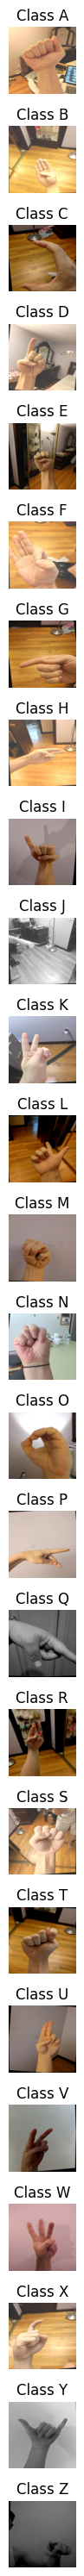

In [11]:
# going to attempt to print an image from each of the classes along with its image


def display_sample_images(class_folders, num_samples_per_class=1):
    """
    Display a few images from each class folder with their proper class labels.
    :param class_folders: List of class folders
    :param num_samples_per_class: Number of images to display from each class
    """
    plt.figure(figsize=(30, 30))  # Set the size of the grid for plotting
    num_images = 0
    total_images_to_show = num_samples_per_class * len(class_folders)

    # Loop over each class folder
    for class_folder in class_folders:
        class_label = os.path.basename(class_folder)  # Extract the class label (e.g., 'A', 'B', etc.)
        
        # Get a list of image filenames in the current class folder
        image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpg')]
        
        # Randomly sample a few image files from this folder
        selected_images = random.sample(image_files, min(num_samples_per_class, len(image_files)))

        for image_file in selected_images:
            image_path = os.path.join(class_folder, image_file)
            
            # Open the image
            img = Image.open(image_path)
            
            # Plot the image
            plt.subplot(len(class_folders), num_samples_per_class, num_images + 1)
            plt.imshow(img)
            plt.title(f"Class {class_label}")
            plt.axis('off')  # Hide axes
            
            num_images += 1
            if num_images >= total_images_to_show:
                break
    
    # Show all the images in the grid
    plt.tight_layout()
    plt.show()

# Call the function to display sample images
display_sample_images(train_class_folders)

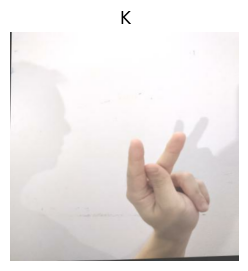

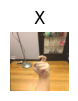

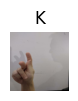

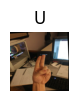

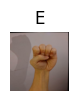

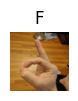

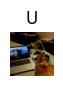

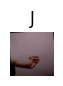

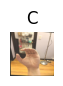

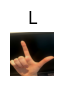

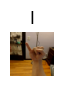

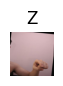

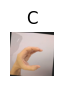

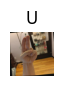

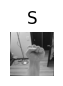

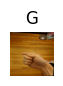

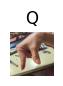

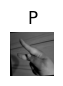

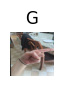

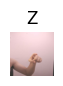

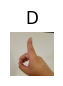

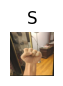

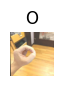

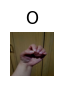

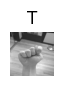

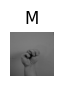

2024-11-19 15:34:59.856186: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
#attempting to do images that are not chatgpt based
# come back and keep working on this code so that:
# no letters repeat
# they are the same size 
# aranged by 6 rows and 6 columns
plt.figure(figsize=(15, 15))
rows = 6
cols = 6
for images, labels in training_dataset.take(1):
  for i in range(26):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    

In [13]:
# moving forward with the model

# Number of classes (26 letters of ASL)
number_of_classes = 26

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # This reduces the spatial dimensions to a single vector
x = Dense(1024, activation='relu')(x)  # A dense layer with 1024 units
predictions = Dense(number_of_classes, activation='softmax')(x)  # 26 output units for ASL letters

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50 so that only the custom layers are trained
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to check the architecture
model.summary()

# Train the model with your dataset
model.fit(training_dataset, train_class_names, epochs=10, validation_data=(validation_dataset, test_class_names))

# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_dataset, test_class_names)

# Print the test accuracy and loss
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 25,712,538 (98.09 MB)

 Trainable params: 2,124,826 (8.11 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

ValueError: When providing `x` as a tf.data.Dataset, `y` should not be passed. Instead, the targets should be included as part of the tf.data.Dataset.